import modules:

In [1]:
import torch
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
# import matplotlib.pyplot as plt
from scvi import REGISTRY_KEYS
from captum.attr import FeatureAblation

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/tornado/ioloop.py:265: DeprecationWarning: There is no current event loop
  loop = asyncio.get_event_loop()
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:2: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.version import LooseVersion
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/captum/attr/_utils/visualization.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `m

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.10.2 pynndescent==0.5.7


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


## load model and data

In [4]:
base_path = '/home/icb/yuge.ji/projects/feature-attribution-sc'
hlca_path = f'{base_path}/datasets/hlca.h5ad'
adata = sc.read(hlca_path)
adata

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/sample' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/sample' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/original_celltype_ann' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packa

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/ann_level_5' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/ann_level_5' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/ann_highest_res' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/ann_new' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/an

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/raw/var/__categories/gene_symbols' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/raw/var/gene_symbols' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/raw/var/n_cells' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/raw/var/highly_variable' was written without encoding metadata.
  return read_elem(dataset)
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.1

AnnData object with n_obs × n_vars = 587218 × 2000
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_ne

Subset because running ablation on the whole adata would be too large.

In [18]:
adata.obs['cell_type_dataset'] = adata.obs.scanvi_label.astype(str) + '-' + adata.obs.dataset.astype(str)
sampled_data = adata.obs.groupby('cell_type_dataset').apply(lambda x: x.sample(min(200, len(x)), random_state=42))
indices = sampled_data.index.get_level_values(1)
adata = adata[indices].copy()

In [19]:
model = scvi.model.SCANVI.load('../../models/scanvi_model/', adata)
model

INFO     File ../../models/scanvi_model/model.pt already downloaded                          


/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/data/_utils.py:156: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scvi/data/_utils.py:156: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, 
dispersion: gene, gene_likelihood: nb
Training status: Trained

get cell type names that match the labels (integers in the model):

In [20]:
ct_names = model.adata_manager.get_state_registry(REGISTRY_KEYS.LABELS_KEY)['categorical_mapping']
ct_names = [ct for ct in ct_names if ct != "unlabeled"]

retrieve the data as a tensor from the dataloader. We'll define batch size to be the size of the whole dataset to do so. In this case we'll set it to the entire size of the subsetted HLCA:

In [21]:
batch_size=adata.shape[0]

create a dataloader and load your first batch (in this case all the cells):

In [22]:
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)   # probably should've removed 'unlabeled' at this point
batch = next(scdl.__iter__())

### assess output of "baseline" zeroes

Construct a fake dataset full of zeros and the respective dataloader.

In [80]:
zero_adata = adata[:10].copy()
zero_adata.X = np.zeros(zero_adata.shape)

In [81]:
zerodl = model._make_data_loader(zero_adata, batch_size=zero_adata.shape[0])
batch = next(zerodl.__iter__())

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


Plot class probabilities. We see that feeding in a baseline of zeros does not provide an equal distribution of classes, but in fact a very high likelihood of being classified as the Basal cell type.

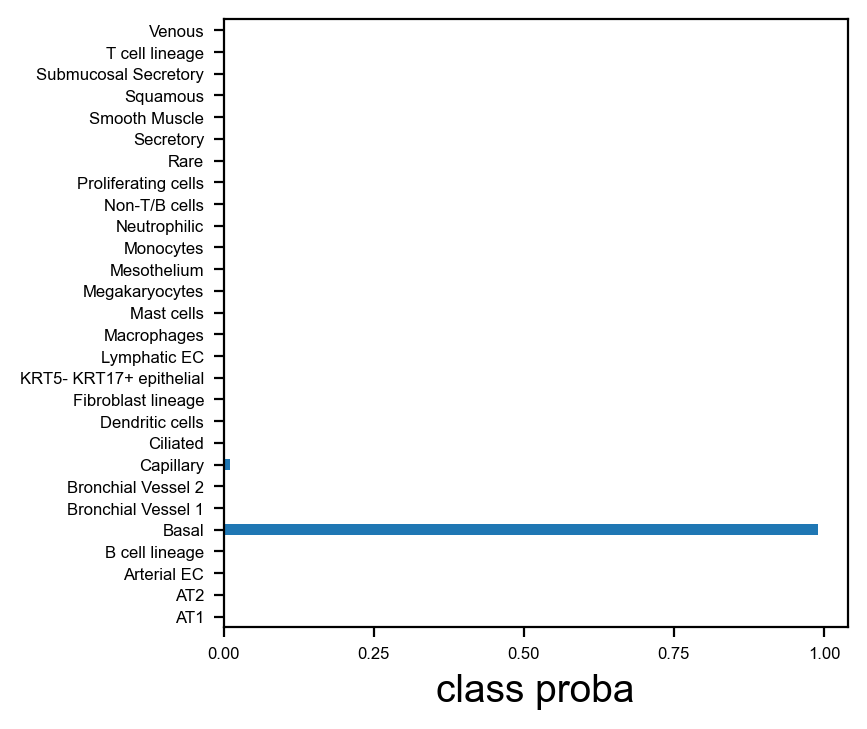

In [82]:
df = pd.DataFrame(model.module.classify(batch['X'], batch['batch'])[0].cpu().detach().numpy(), index=ct_names)

df.plot.barh(figsize=(4, 4), fontsize=6, legend=False)
# plt.xscale('log')
plt.xlabel('class proba')
plt.grid(None)

In [83]:
hlca = sc.read(f'{base_path}/datasets/hlca.h5ad')

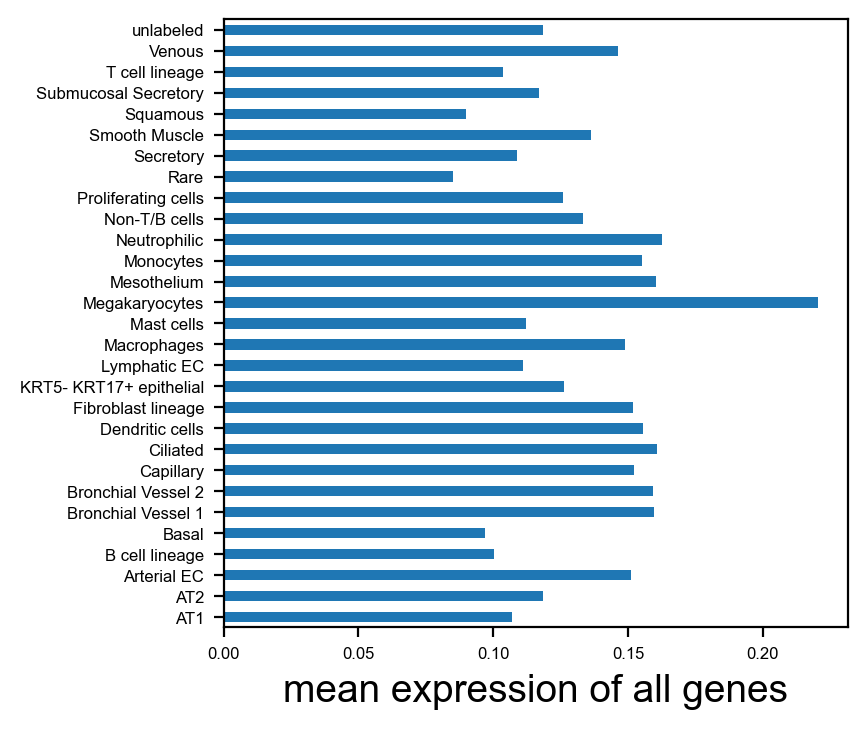

In [84]:
df = pd.DataFrame([hlca[hlca.obs.scanvi_label == ct].X.mean() for ct in hlca.obs.scanvi_label.cat.categories], index=hlca.obs.scanvi_label.cat.categories)
df.plot.barh(figsize=(4, 4), fontsize=6, legend=False)
plt.xlabel('mean expression of all genes')
plt.grid(None)

### Measure feature attribution with respect to classification probabilities

create the ablator, containing the forward function inside of it:

In [23]:
ablator = FeatureAblation(model.module.classify)

Run the feature attribution function. The attribution below outputs two tensors. One ablates the gene features one by one, for every cell, and has shape (n_cells * n_ct_classes) * n_genes. The other ablates the (biological) batch variable, which it takes as a single, continuous variable (even though it is a one-hot encoded (n_datasets)-dimensional variable), and therefore ablates it once per cell, and outputs a (n_cells * n_ct_classes) * 1 shape tensor. We'll ignore that one.

In [53]:
pred = model.module.classify(batch['X'], batch['batch'])

In [24]:
%%time
# per feature per output
attribution_map = ablator.attribute((batch['X'], batch['batch']), show_progress=True)

Feature Ablation attribution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2002/2002 [1:21:00<00:00,  2.43s/it]

CPU times: user 5h 12min 6s, sys: 2h 28min 36s, total: 7h 40min 43s
Wall time: 1h 21min


In [25]:
attribution_map_genes = attribution_map[0] # take only the first tensor (explained above)

reshape, such that n_cells\*n_classes is split into two dimensions ((n_cells*28) becomes n_cells*28). This is 28 because the original classifier was trained the 28 `scanvi_label` categories (not including `'unlabeled'`)

In [43]:
attribution_map_genes_3d = attribution_map_genes.reshape((batch_size,28,adata.shape[1]))

Save so that we can examine patterns in the values themselves using the plotting library from SHAP.

In [27]:
adata.obs.to_csv('attribution_map_obs_scanvi_ablation.csv')
with open('attribution_map_genes_3d_scanvi_ablation.npy', 'wb') as f:
    np.save(f, attribution_map_genes_3d)

In [28]:
attribution_map_genes.min()

tensor(-1.0000)

In [29]:
attribution_map_genes.max()

tensor(1.0000)

For each class, calculate mean only across cells of that class (= cell type), ignore other cells. Then take only the feature importances for that particular class. Reasoning: we want to learn which features were important for classifing a cell of cell type a *as* cell type a, and not the features that made the model *not* classify it as cell type a (the latter would give negative markers rather than positive ones).

In [30]:
means = pd.DataFrame(index=adata.var_names,columns=ct_names)
means_abs = pd.DataFrame(index=adata.var_names,columns=ct_names)

In [57]:
for ct in batch['labels'].unique():
    ct_float = ct.item()
    ct_int = int(ct_float)
    if ct_int == 28:  # 'unlabeled'
        continue
    ct_indexing = (batch['labels'] == ct_float).reshape(-1)
    means.iloc[:,ct_int] = torch.mean(attribution_map_genes_3d[ct_indexing, ct_int,:], dim=0)
    means_abs.iloc[:,ct_int] = torch.mean(attribution_map_genes_3d[ct_indexing, ct_int,:].abs(), dim=0)

Store ranking table.

In [59]:
means.to_csv("../../outputs/ablation/task2.csv")
means_abs.to_csv("../../outputs/ablation/task2_abs.csv")

## look at non-absolute ablation values

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
genes = means.sort_values(by='AT2').index[-5:]

<AxesSubplot: >

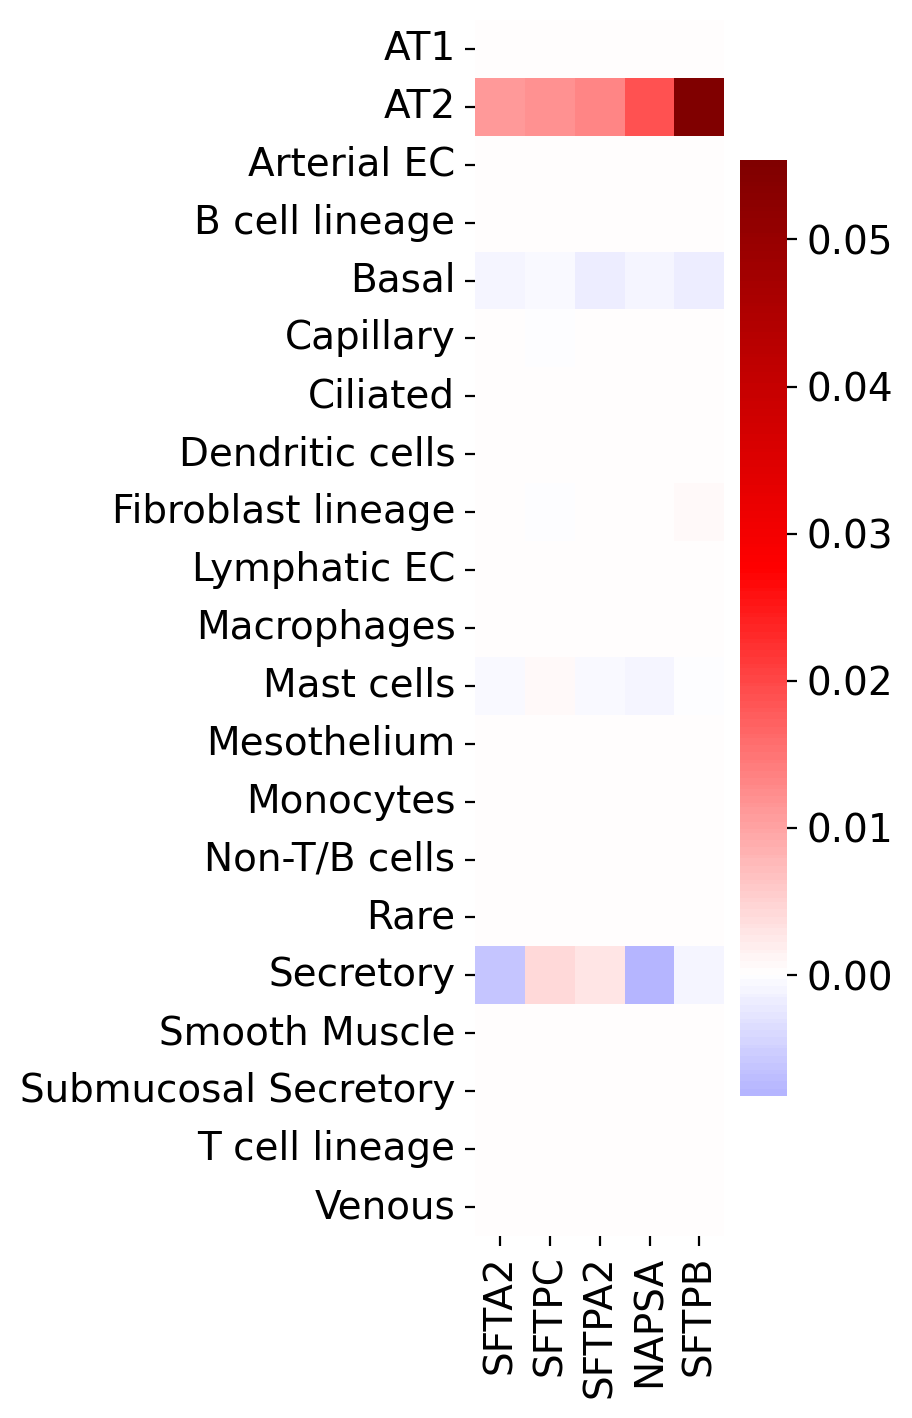

In [65]:
plt.figure(figsize=(2, 8))
sns.heatmap(means.loc[genes].dropna(axis=1).T, cmap='seismic', center=0)

/tmp/ipykernel_437855/2134295218.py:2: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


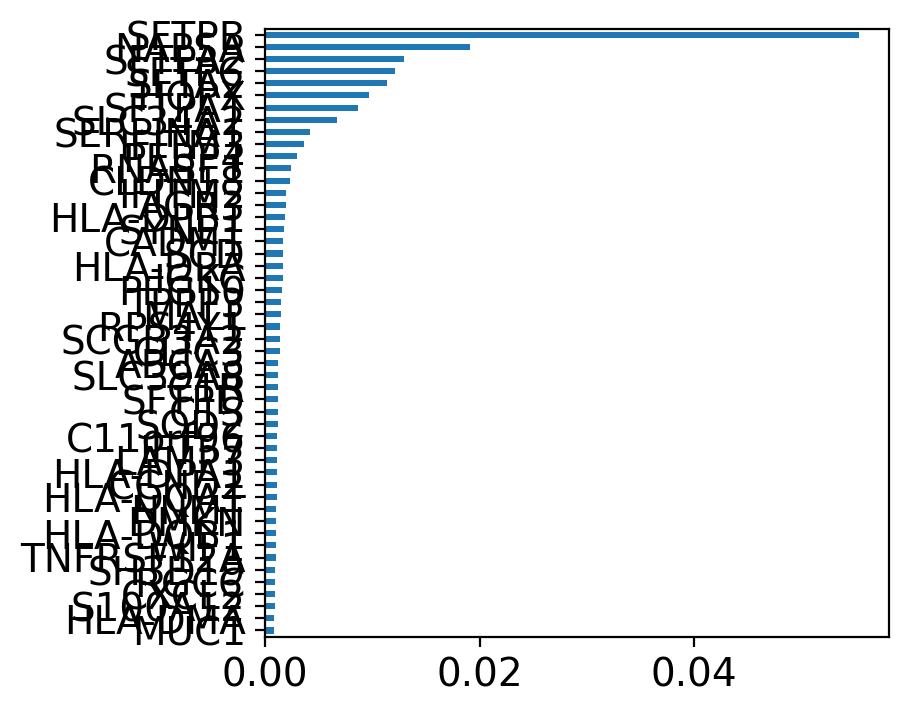

In [73]:
means[['AT2']].sort_values(by='AT2')[-50:].plot.barh(legend=False)
plt.grid(b=None)

We see that surfactant proteins, primarily produced by AT2 cells, are positive indicators for the cell type, and generally negative indicators elsewhere.

### measure against latent (to do)